Imports.

In [1]:
import polars as pl
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import platform
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import random

In [2]:
print(torch.__version__, torch.cuda.is_available(), platform.python_version())
device = "mps" if torch.backends.mps.is_available() else "cpu"

2.7.1 False 3.12.1


Load the dataset.

In [3]:
ds_train = MNIST(root=".", download=True, train=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 26.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.00MB/s]


Sanity checks.

shape: (10, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ i64   ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 5923  │
│ 1     ┆ 6742  │
│ 2     ┆ 5958  │
│ 3     ┆ 6131  │
│ 4     ┆ 5842  │
│ 5     ┆ 5421  │
│ 6     ┆ 5918  │
│ 7     ┆ 6265  │
│ 8     ┆ 5851  │
│ 9     ┆ 5949  │
└───────┴───────┘


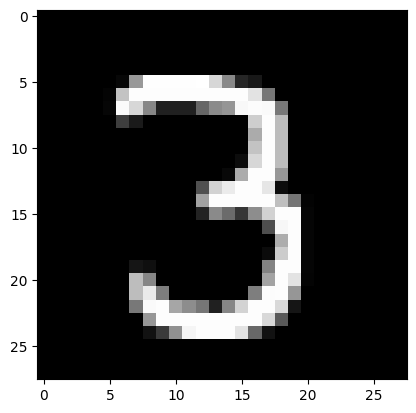

In [4]:
# flatten images / process data
labels = pl.Series(name="label", values=ds_train.targets)
print(labels.value_counts().sort("label"))

random_num = ds_train.data[random.randint(0, len(ds_train))]
plt.imshow(random_num.reshape((28, 28)), cmap="gray")
plt.show()

Define the MLP.

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim=784, hidden_dim=128, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.net(x)

Instantiate training pre-conditions.

In [6]:
EPOCHS = 10
BATCH_SIZE = 128

In [7]:
train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
model = MLP().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()

Training loop.

In [8]:
losses = np.zeros((len(train), EPOCHS))
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    train_iter = iter(train)
    for sample_idx, (imgs, labels) in enumerate(train_iter):
        imgs = imgs.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += loss.item()
        losses[sample_idx, epoch] = loss.item()
    avg = running_loss / len(train)
    print(f"Epoch {epoch+1}/{EPOCHS}  |  loss: {avg:.4f}")

 10%|█         | 1/10 [00:03<00:34,  3.79s/it]

Epoch 1/10  |  loss: 0.9858


 20%|██        | 2/10 [00:06<00:23,  2.92s/it]

Epoch 2/10  |  loss: 0.3509


 30%|███       | 3/10 [00:08<00:18,  2.64s/it]

Epoch 3/10  |  loss: 0.2909


 40%|████      | 4/10 [00:10<00:15,  2.54s/it]

Epoch 4/10  |  loss: 0.2504


 50%|█████     | 5/10 [00:13<00:12,  2.43s/it]

Epoch 5/10  |  loss: 0.2171


 60%|██████    | 6/10 [00:15<00:09,  2.37s/it]

Epoch 6/10  |  loss: 0.1904


 70%|███████   | 7/10 [00:17<00:07,  2.34s/it]

Epoch 7/10  |  loss: 0.1685


 80%|████████  | 8/10 [00:19<00:04,  2.26s/it]

Epoch 8/10  |  loss: 0.1515


 90%|█████████ | 9/10 [00:21<00:02,  2.20s/it]

Epoch 9/10  |  loss: 0.1373


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]

Epoch 10/10  |  loss: 0.1253


Text(0, 0.5, 'Cross-entropy loss')

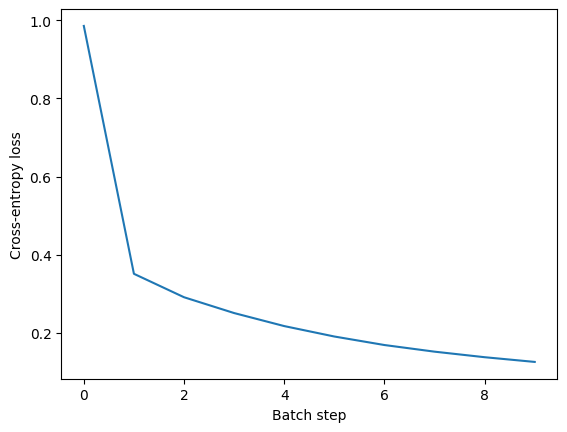

In [9]:
average_epoch_losses = np.mean(losses, axis=0)
plt.plot(average_epoch_losses)
plt.xlabel("Batch step")
plt.ylabel("Cross-entropy loss")

Evaluation.

In [10]:
ds_test = MNIST(root=".", download=True, train=False)
model.eval()                                # turn off dropout/BN (habit)

with torch.no_grad():
    imgs = ds_test.data.view(-1, 28*28).float().div_(255).to(device)
    labels = ds_test.targets.to(device)

    logits = model(imgs)
    preds = logits.argmax(dim=1)

    correct = (preds == labels).sum().item()
    total = labels.size(0)

print(f"Accuracy: {correct / total:.2%}")                            # restore training mode

Accuracy: 96.24%
